# Importing Libraries

In [1]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 7.3 MB/s 


In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras import backend as K
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Importing Dataset

In [3]:
df = pd.read_csv('parkinsons_updrs.csv')

In [4]:
df.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subject#       5875 non-null   int64  
 1   age            5875 non-null   int64  
 2   sex            5875 non-null   int64  
 3   test_time      5875 non-null   float64
 4   motor_UPDRS    5875 non-null   float64
 5   total_UPDRS    5875 non-null   float64
 6   Jitter(%)      5875 non-null   float64
 7   Jitter(Abs)    5875 non-null   float64
 8   Jitter:RAP     5875 non-null   float64
 9   Jitter:PPQ5    5875 non-null   float64
 10  Jitter:DDP     5875 non-null   float64
 11  Shimmer        5875 non-null   float64
 12  Shimmer(dB)    5875 non-null   float64
 13  Shimmer:APQ3   5875 non-null   float64
 14  Shimmer:APQ5   5875 non-null   float64
 15  Shimmer:APQ11  5875 non-null   float64
 16  Shimmer:DDA    5875 non-null   float64
 17  NHR            5875 non-null   float64
 18  HNR     

In [6]:
df.isnull().sum()

subject#         0
age              0
sex              0
test_time        0
motor_UPDRS      0
total_UPDRS      0
Jitter(%)        0
Jitter(Abs)      0
Jitter:RAP       0
Jitter:PPQ5      0
Jitter:DDP       0
Shimmer          0
Shimmer(dB)      0
Shimmer:APQ3     0
Shimmer:APQ5     0
Shimmer:APQ11    0
Shimmer:DDA      0
NHR              0
HNR              0
RPDE             0
DFA              0
PPE              0
dtype: int64

No null values found in the dataset

In [7]:
df.describe()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
count,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000
mean,21.494128,64.804936,0.317787,92.863722,21.296229,29.018942,0.006154,0.000044,0.002987,0.003277,0.008962,0.034035,0.310960,0.017156,0.020144,0.027481,0.051467,0.032120,21.679495,0.541473,0.653240,0.219589
std,12.372279,8.821524,0.465656,53.445602,8.129282,10.700283,0.005624,0.000036,0.003124,0.003732,0.009371,0.025835,0.230254,0.013237,0.016664,0.019986,0.039711,0.059692,4.291096,0.100986,0.070902,0.091498
min,1.000000,36.000000,0.000000,-4.262500,5.037700,7.000000,0.000830,0.000002,0.000330,0.000430,0.000980,0.003060,0.026000,0.001610,0.001940,0.002490,0.004840,0.000286,1.659000,0.151020,0.514040,0.021983
25%,10.000000,58.000000,0.000000,46.847500,15.000000,21.371000,0.003580,0.000022,0.001580,0.001820,0.004730,0.019120,0.175000,0.009280,0.010790,0.015665,0.027830,0.010955,19.406000,0.469785,0.596180,0.156340
50%,22.000000,65.000000,0.000000,91.523000,20.871000,27.576000,0.004900,0.000035,0.002250,0.002490,0.006750,0.027510,0.253000,0.013700,0.015940,0.022710,0.041110,0.018448,21.920000,0.542250,0.643600,0.205500
75%,33.000000,72.000000,1.000000,138.445000,27.596500,36.399000,0.006800,0.000053,0.003290,0.003460,0.009870,0.039750,0.365000,0.020575,0.023755,0.032715,0.061735,0.031463,24.444000,0.614045,0.711335,0.264490
max,42.000000,85.000000,1.000000,215.490000,39.511000,54.992000,0.099990,0.000446,0.057540,0.069560,0.172630,0.268630,2.107000,0.162670,0.167020,0.275460,0.488020,0.748260,37.875000,0.966080,0.865600,0.731730


Here we can see a weird discrepancy in the data. The min value of "test_time" is negative. 

From the UCI ML Repository, the description of "test_time" is as follows: "Time since recruitment into the trial. The integer part is the number of days since recruitment."

How can that be negative for a patient?

In [8]:
df[df['test_time'] < 0].count()

subject#         12
age              12
sex              12
test_time        12
motor_UPDRS      12
total_UPDRS      12
Jitter(%)        12
Jitter(Abs)      12
Jitter:RAP       12
Jitter:PPQ5      12
Jitter:DDP       12
Shimmer          12
Shimmer(dB)      12
Shimmer:APQ3     12
Shimmer:APQ5     12
Shimmer:APQ11    12
Shimmer:DDA      12
NHR              12
HNR              12
RPDE             12
DFA              12
PPE              12
dtype: int64

We have 12 such entries that have a negative "test_time". It is better to drop these entries to avoid confusion for the models.

In [9]:
df = df[df['test_time'] > 0]

## Correlation Matrix

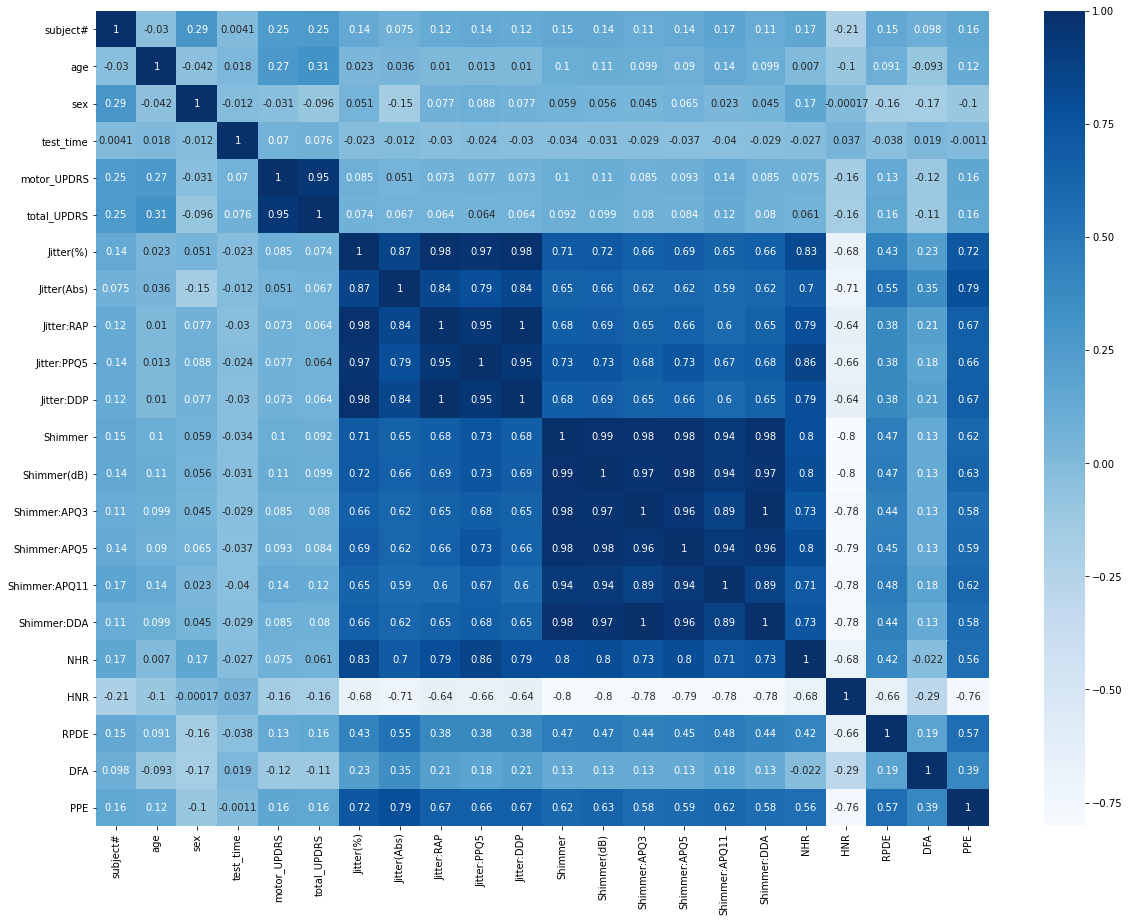

In [10]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(), annot=True, cmap='Blues')

As we can see, the data is highly correlated. Let us use Principal Component Analysis to narrow down the correlated features.

## PCA

In [366]:
data = df.copy()

Let us drop "subject#" from the dataset entirely as it not useful for our model. 

Let us also seperate the target variables before applying PCA.

In [367]:
data.drop(['subject#'], axis=1, inplace=True)

In [368]:
y1 = data['motor_UPDRS']
y2 = data['total_UPDRS']
data.drop(['motor_UPDRS', 'total_UPDRS'], axis=1, inplace=True)

## Splitting the data into Training and Test Set

In [369]:
x1_train, x1_test, y1_train, y1_test = train_test_split(data, y1, test_size=0.2, random_state=42)
x2_train, x2_test, y2_train, y2_test = train_test_split(data, y2, test_size=0.2, random_state=42)

I will use x1_train to perform PCA tests.

In [370]:
pca = PCA(n_components=14)
principal_components = pca.fit_transform(data)

In [371]:
pca_df = pd.DataFrame(principal_components, columns=['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6','PCA7','PCA8','PCA9','PCA10','PCA11','PCA12','PCA13','PCA14'])

In [372]:
pca_df.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14
0,-87.395804,-7.420439,-0.726184,-0.305428,-0.061443,-0.145538,-0.117522,-0.039417,-0.005717,0.004253,-0.005202,0.007683,-0.000184,0.000895
1,-80.356512,-7.029604,-6.230253,-0.300305,0.123614,-0.029321,-0.056080,-0.010225,0.015743,0.000700,0.001452,0.001396,-0.000623,0.000759
2,-73.353852,-7.286398,-2.084574,-0.306433,-0.051730,-0.065026,-0.080630,-0.084761,-0.003402,-0.005916,-0.003816,0.000107,-0.000292,0.000044
3,-67.383779,-7.176695,-3.449752,-0.303573,0.151028,0.019233,0.044212,-0.143779,-0.033837,-0.014053,-0.013288,-0.008359,-0.001464,-0.003801
4,-59.383841,-7.040801,-5.108805,-0.302410,0.073341,0.003149,-0.031279,-0.068282,-0.002099,-0.006452,0.001422,-0.001590,-0.000216,0.000102


Plotting a Scree plot to perform the Elbow method to find the ideal components of PCA

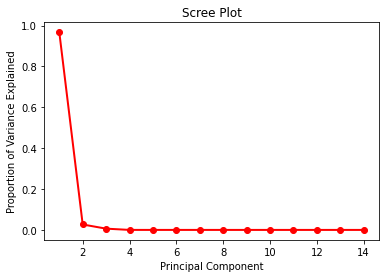

In [373]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [374]:
print(pca.explained_variance_)

[2.84316873e+03 7.81730907e+01 1.81791690e+01 2.17453979e-01
 2.05138259e-02 5.55632337e-03 5.02483651e-03 2.68092818e-03
 1.00518116e-03 1.03934678e-04 4.52955553e-05 3.22145711e-05
 6.80769578e-06 3.37466484e-06]


Hence we decide to keep 8 Principal Components as from the 9th value onwards, the Eigen Values are tending to 0.

The reason we seperated the data into training and test set so early is due avoid information leakage and overfitting of our model. 

The model should never have seen the test data to evaluate it's performance accurately.

In [375]:
pca1 = PCA(n_components=8, random_state=42)
pca2 = PCA(n_components=8, random_state=42)
x1_train = pca1.fit_transform(x1_train)
x1_test = pca1.transform(x1_test)

x2_train = pca2.fit_transform(x2_train)
x2_test = pca2.transform(x2_test)

Our data is ready to be fitted into Regression Models.

## Function for Evaluating Model Performance

In [376]:
def score(y_pred,y_test):
    mae = mean_absolute_error(y_test,y_pred)
    mse = mean_squared_error(y_test,y_pred)
    r2 = r2_score(y_test,y_pred)*100
    print("Mean Absolute Error: ", mae)
    print("Mean Squared Error: ", mse)
    print("R2 score: ", r2,)
    return (mae, mse, r2)

# Models

## Y1 Variabale: motor_UPDRS

### Decision Tree Regression

In [384]:
dt_reg1 = DecisionTreeRegressor()
dt_reg1.fit(x1_train, y1_train)
y_dt_pred1 = dt_reg1.predict(x1_test)

In [385]:
dt_mae1, dt_mse1, dt_r21 = score(y1_test, y_dt_pred1)

Mean Absolute Error:  0.942073516624041
Mean Squared Error:  9.442047170143377
R2 score:  85.52014600999942


### Random Forrest Regression

In [386]:
rf_reg1 = RandomForestRegressor()
rf_reg1.fit(x1_train, y1_train)
y_rf_pred1 = rf_reg1.predict(x1_test)

In [387]:
rf_mae1, rf_mse1, rf_r21 = score(y1_test, y_rf_pred1)

Mean Absolute Error:  0.9136763593210668
Mean Squared Error:  4.275667321545525
R2 score:  92.65658721935115


### XGBoost Regression

In [388]:
xgb_reg1 = XGBRegressor(objective='reg:squarederror')
xgb_reg1.fit(x1_train, y1_train)
y_xgb_pred1 = xgb_reg1.predict(x1_test)

In [389]:
xgb_mae1, xgb_mse1, xgb_r21 = score(y1_test, y_xgb_pred1)

Mean Absolute Error:  3.1709770370008594
Mean Squared Error:  16.565637525423284
R2 score:  52.28754253207616


## Comparing Model1 Performance

In [390]:
model_mae1 = [dt_mae1, rf_mae1, xgb_mae1]
model_mse1 = [dt_mse1, rf_mse1, xgb_mse1]
model_r21 = [dt_r21, rf_r21, xgb_r21]
models=["Decision Tree", "Random Forrest", "XGBoost"]

Text(0.5, 1.0, 'Comparing Model1 MAE(Test Set)')

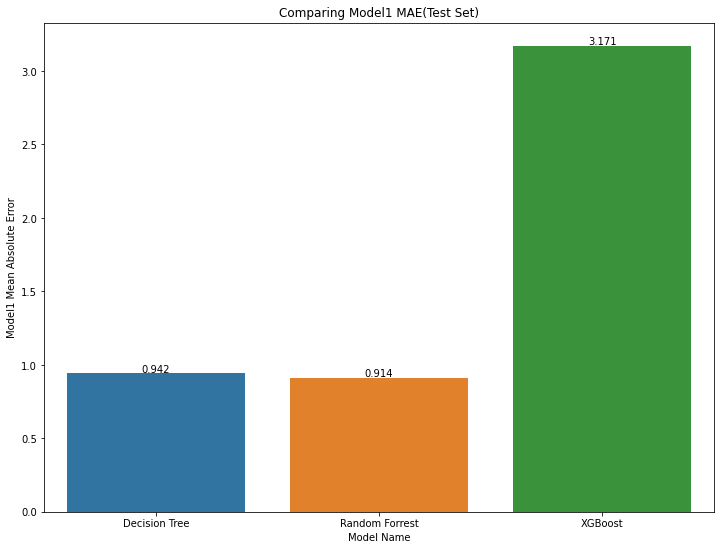

In [391]:
plt.figure(figsize=(12,9))
ax = sns.barplot(x=models, y=model_mae1)
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height+0.01,
          '{:1.3f}'.format(height),
          ha='center')
  
plt.ylabel('Model1 Mean Absolute Error')
plt.xlabel('Model Name')
plt.title('Comparing Model1 MAE(Test Set)')

Text(0.5, 1.0, 'Comparing Model1 MSE(Test Set)')

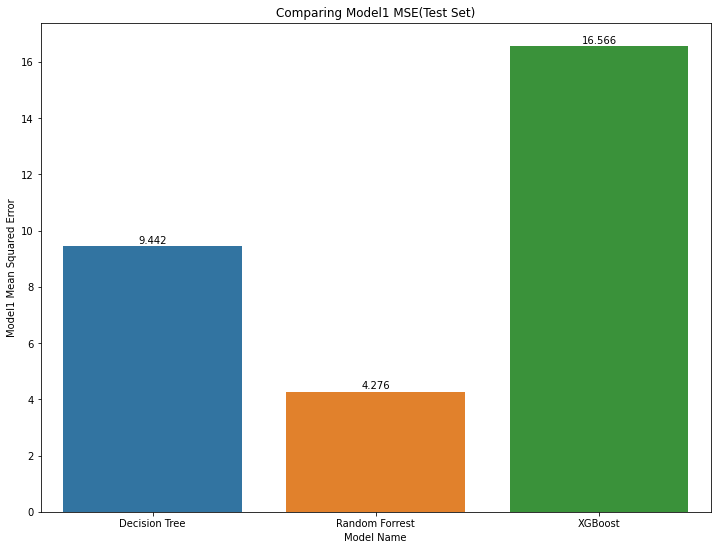

In [392]:
plt.figure(figsize=(12,9))
ax = sns.barplot(x=models, y=model_mse1)
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height+0.1,
          '{:1.3f}'.format(height),
          ha='center')
  
plt.ylabel('Model1 Mean Squared Error')
plt.xlabel('Model Name')
plt.title('Comparing Model1 MSE(Test Set)')

Text(0.5, 1.0, 'Comparing Model1 R2 Score(Test Set)')

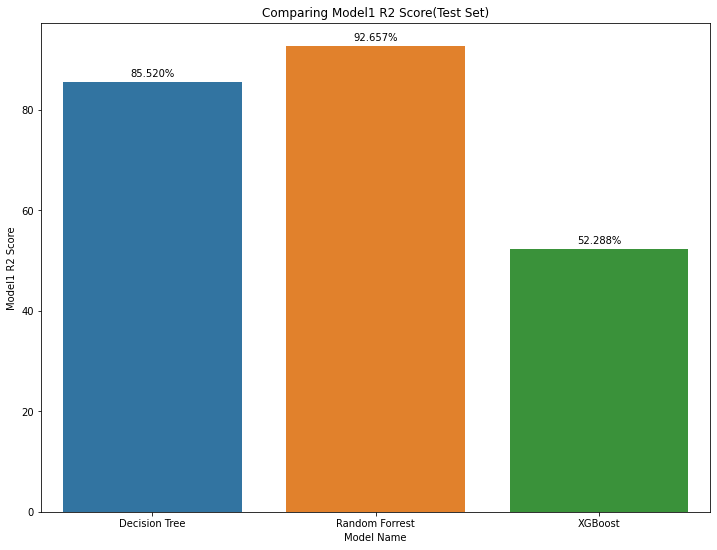

In [393]:
plt.figure(figsize=(12,9))
ax = sns.barplot(x=models, y=model_r21)
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height + 1,
          '{:1.3f}%'.format(height),
          ha='center')
  
plt.ylabel('Model1 R2 Score')
plt.xlabel('Model Name')
plt.title('Comparing Model1 R2 Score(Test Set)')

### Performing Cross Validation for our models.

#### R2 Score

In [394]:
dt_cv1 = cross_val_score(dt_reg1,x1_train, y1_train, cv=10, scoring='r2')
rf_cv1 = cross_val_score(rf_reg1,x1_train, y1_train, cv=10, scoring='r2')
xgb_cv1 = cross_val_score(xgb_reg1,x1_train, y1_train, cv=10, scoring='r2')

In [427]:
print("Cross Validation Score for Decision Tree Regression is: {:1.3f} +- {:1.3f}".format(dt_cv1.mean()*100, dt_cv1.std()*100))
print("Cross Validation Score for Random Forrest Regression is: {:1.3f} +- {:1.3f}".format(rf_cv1.mean()*100, rf_cv1.std()*100))
print("Cross Validation Score for XGBoost Model is: {:1.3f} +- {:1.3f}".format(xgb_cv1.mean()*100, xgb_cv1.std()*100))

Cross Validation Score for Decision Tree Regression is: 85.034 +- 4.941
Cross Validation Score for Random Forrest Regression is: 93.534 +- 1.967
Cross Validation Score for XGBoost Model is: 75.069 +- 1.807


#### Thus Random Forrest Regression is the best model for Y1 Variable(motor_UPDRS) with a **MAE of 0.914 and R2 score of 93.5%**

## Y2 Variable: total_UPDRS

The Correlation Matrix gave us an interesting insight. "motor_UPDRS" and "total_UPDRS" are highly correlated(0.95).

In our current dataset, we already have the recorded data of "motor_UPDRS". But for future predictions, that might not be the case.

Hence we can use feature engineering to get a new highly correlated feature using our Model 1 for the "total_UPDRS" prediction.

We will use Random Forrest predictions as the new feature for our Model 2 as it was the best performing model.

### Adding the "motor_UPDRS" values predicted by our Model 1 to the second training and test set.

In [396]:
motor_train = rf_reg1.predict(x1_train)
motor_test = rf_reg1.predict(x1_test)

In [397]:
x2_train = pd.DataFrame(x2_train, columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4','PCA5', 'PCA6', 'PCA7', 'PCA8'])

In [398]:
x2_test = pd.DataFrame(x2_test, columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4','PCA5', 'PCA6', 'PCA7', 'PCA8'])

In [399]:
x2_train['motor_UPDRS'] = motor_train

In [400]:
x2_test['motor_UPDRS'] = motor_test

### Linear Regression

In [401]:
lin_reg2 = LinearRegression()
lin_reg2.fit(x2_train, y2_train)
y_lin_pred2 = lin_reg2.predict(x2_test)

In [402]:
lin_mae2, lin_mse2, lin_r22 = score(y2_test,y_lin_pred2)

Mean Absolute Error:  2.960427956585426
Mean Squared Error:  16.53203615865384
R2 score:  82.69965922008123


### Polynomial Regression

In [403]:
poly2 = PolynomialFeatures(degree=3)
x2_poly = poly2.fit_transform(x2_train)

In [404]:
poly_reg2 = LinearRegression()
poly_reg2.fit(x2_poly, y2_train)
y_poly_pred2 = poly_reg2.predict(poly2.transform(x2_test))

In [405]:
poly_mae2, poly_mse2, poly_r22 = score(y2_test, y_poly_pred2)

Mean Absolute Error:  2.1554500447456104
Mean Squared Error:  10.919422916826134
R2 score:  89.07075636029755


### Support Vector Machines

In [406]:
svr_reg2 = SVR()
svr_reg2.fit(x2_train, y2_train)
y_svr_pred2 = svr_reg2.predict(x2_test)

In [407]:
svr_mae2, svr_mse2, svr_r22 = score(y2_test, y_svr_pred2)

Mean Absolute Error:  2.986393284271332
Mean Squared Error:  18.137970644321957
R2 score:  77.82258112079464


### Decision Tree Regression

In [408]:
dt_reg2 = DecisionTreeRegressor()
dt_reg2.fit(x2_train, y2_train)
y_dt_pred2 = dt_reg2.predict(x2_test)

In [409]:
dt_mae2, dt_mse2, dt_r22 = score(y2_test, y_dt_pred2)

Mean Absolute Error:  1.0586329624893436
Mean Squared Error:  9.495246058284932
R2 score:  91.26448859263377


### Random Forrest Regression

In [410]:
rf_reg2 = RandomForestRegressor()
rf_reg2.fit(x2_train, y2_train)
y_rf_pred2 = rf_reg2.predict(x2_test)

In [411]:
rf_mae2, rf_mse2, rf_r22 = score(y2_test, y_rf_pred2)

Mean Absolute Error:  1.0525700385121561
Mean Squared Error:  8.044958744297203
R2 score:  92.44488679677225


### XGBoost Regression

In [412]:
xgb_reg2 = XGBRegressor(objective='reg:squarederror')
xgb_reg2.fit(x2_train, y2_train)
y_xgb_pred2 = xgb_reg2.predict(x2_test)

In [413]:
xgb_mae2, xgb_mse2, xgb_r22 = score(y2_test, y_xgb_pred2)

Mean Absolute Error:  1.8854081725690475
Mean Squared Error:  9.290810337603014
R2 score:  90.76848363805861


## Comparing Model2 Performance

In [416]:
model_mae2 = [lin_mae2,poly_mae2, svr_mae2, dt_mae2, rf_mae2, xgb_mae2]
model_mse2 = [lin_mse2,poly_mse2, svr_mse2, dt_mse2, rf_mse2, xgb_mse2]
model_r22 = [lin_r22,poly_r22, svr_r22, dt_r22, rf_r22, xgb_r22]
models2 = ["Linear Regression", "Polynomial Regression", "Support Vector Machines","Decision Tree", "Random Forrest", "XGBoost"]

Text(0.5, 1.0, 'Comparing Model2 MAE(Test Set)')

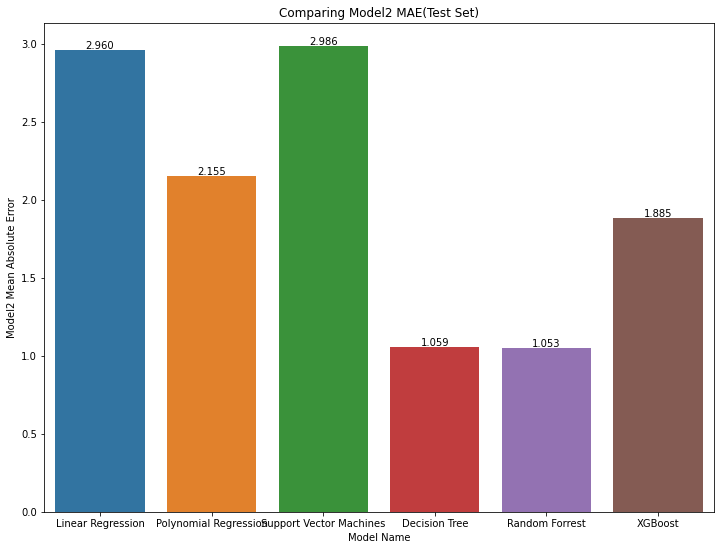

In [419]:
plt.figure(figsize=(12,9))
ax = sns.barplot(x=models2, y=model_mae2)
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height+0.01,
          '{:1.3f}'.format(height),
          ha='center')
  
plt.ylabel('Model2 Mean Absolute Error')
plt.xlabel('Model Name')
plt.title('Comparing Model2 MAE(Test Set)')

Text(0.5, 1.0, 'Comparing Model2 MSE(Test Set)')

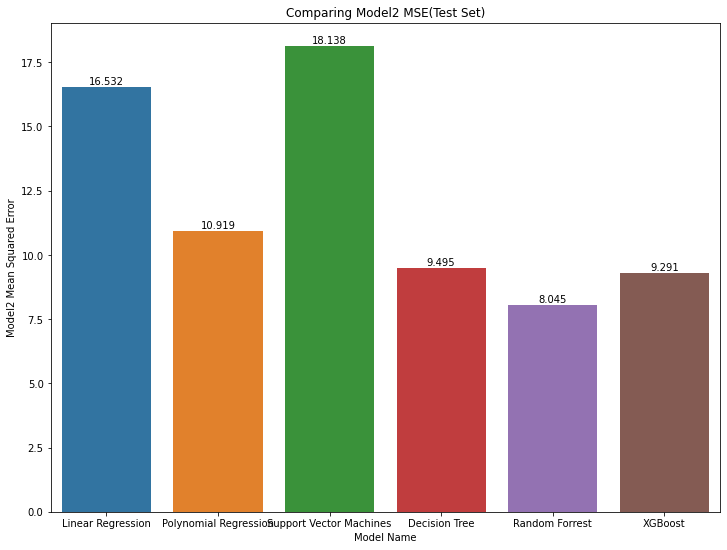

In [422]:
plt.figure(figsize=(12,9))
ax = sns.barplot(x=models2, y=model_mse2)
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height+0.1,
          '{:1.3f}'.format(height),
          ha='center')
  
plt.ylabel('Model2 Mean Squared Error')
plt.xlabel('Model Name')
plt.title('Comparing Model2 MSE(Test Set)')

Text(0.5, 1.0, 'Comparing Model2 R2 Score(Test Set)')

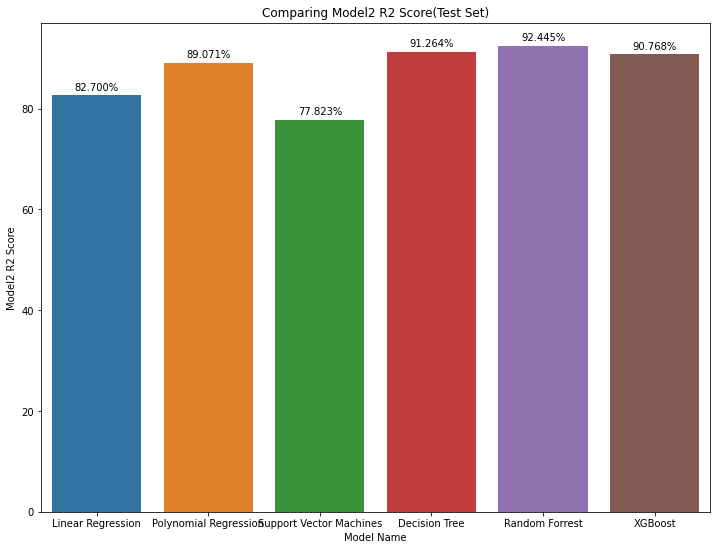

In [423]:
plt.figure(figsize=(12,9))
ax = sns.barplot(x=models2, y=model_r22)
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height + 1,
          '{:1.3f}%'.format(height),
          ha='center')
  
plt.ylabel('Model2 R2 Score')
plt.xlabel('Model Name')
plt.title('Comparing Model2 R2 Score(Test Set)')

### Performing Cross Validation for our 3 best performing models

In [424]:
dt_cv2 = cross_val_score(dt_reg2,x2_train, y2_train, cv=10, scoring='r2')
rf_cv2 = cross_val_score(rf_reg2,x2_train, y2_train, cv=10, scoring='r2')
xgb_cv2 = cross_val_score(xgb_reg2,x2_train, y2_train, cv=10, scoring='r2')

In [426]:
print("Cross Validation Score for Decision Tree Regression is: {:1.3f} +- {:1.3f}".format(dt_cv2.mean()*100, dt_cv2.std()*100))
print("Cross Validation Score for Random Forrest Regression is: {:1.3f} +- {:1.3f}".format(rf_cv2.mean()*100, rf_cv2.std()*100))
print("Cross Validation Score for XGBoost Model is: {:1.3f} +- {:1.3f}".format(xgb_cv2.mean()*100, xgb_cv2.std()*100))

Cross Validation Score for Decision Tree Regression is: 98.469 +- 0.491
Cross Validation Score for Random Forrest Regression is: 99.244 +- 0.244
Cross Validation Score for XGBoost Model is: 97.100 +- 0.209


#### Thus Random Forrest Regressionis is the best model for Y2 Variable(total_UPDRS) with a **MAE of 1.053 and R2 score of 99.24%**

# Deep Learning Approach

In [428]:
df.drop(['subject#'], axis=1, inplace=True)

In [429]:
df.head()

,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [430]:
y = df.iloc[:, [3,4]].values

In [431]:
df.drop(['motor_UPDRS', 'total_UPDRS'], axis=1, inplace=True)

In [432]:
x = df.values

### Splitting data into Training and Test set

In [433]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

### Standardizing so that the Standard deviation is 1 and mean is 0 for all features.

In [434]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

### Artificial Neural Network

In [444]:
ann1 = Sequential([
                   Dense(units=128, activation='relu'),
                   Dropout(0.2),
                   Dense(units=64, activation='relu'),
                   Dropout(0.2),
                   Dense(units=32, activation='relu'),
                   Dropout(0.2),
                   Dense(units=16, activation='relu'),
                   Dense(units=2)
])

In [445]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [446]:
ann1.compile(optimizer='adam', loss="mean_absolute_error", metrics=[r2, 'mae'])

In [447]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_r2') > 0.99):
            print("\nReached 99% R2 score so cancelling training!")
            self.model.stop_training = True
        
callback = myCallback()

In [448]:
r1 = ann1.fit(x_train, y_train,
              validation_data=(x_test, y_test), batch_size=64, epochs=700, callbacks=[callback])

Epoch 1/700
74/74 [==============================] - 1s 5ms/step - loss: 18.8657 - r2: -3.8417 - mae: 18.8657 - val_loss: 10.5359 - val_r2: -0.8705 - val_mae: 10.5359
Epoch 2/700
74/74 [==============================] - 0s 3ms/step - loss: 9.2757 - r2: -0.4046 - mae: 9.2757 - val_loss: 8.0388 - val_r2: 0.0229 - val_mae: 8.0388
Epoch 3/700
74/74 [==============================] - 0s 3ms/step - loss: 8.1306 - r2: -0.0473 - mae: 8.1306 - val_loss: 7.5868 - val_r2: 0.0889 - val_mae: 7.5868
Epoch 4/700
74/74 [==============================] - 0s 3ms/step - loss: 7.8265 - r2: 0.0212 - mae: 7.8265 - val_loss: 7.1636 - val_r2: 0.2037 - val_mae: 7.1636
Epoch 5/700
74/74 [==============================] - 0s 3ms/step - loss: 7.4376 - r2: 0.1038 - mae: 7.4376 - val_loss: 7.0182 - val_r2: 0.1951 - val_mae: 7.0182
Epoch 6/700
74/74 [==============================] - 0s 3ms/step - loss: 7.1157 - r2: 0.1790 - mae: 7.1157 - val_loss: 6.7132 - val_r2: 0.2718 - val_mae: 6.7132
Epoch 7/700
74/74 [=======

In [449]:
ann1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               2560      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)               

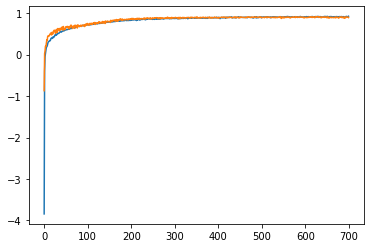

In [450]:
plt.plot(r1.history['r2'], label='R2')
plt.plot(r1.history['val_r2'], label='Val_R2')

In [452]:
ann_score = ann1.evaluate(x_test, y_test)

37/37 [==============================] - 0s 2ms/step - loss: 2.0241 - r2: 0.8905 - mae: 2.0241


In [456]:
ann_r2 = ann_score[1]*100

Our Neural Network gave us a **MAE of 2.02** and **R2 score of 90%**

We are getting a **R2 of 90%** which is considerably lower than the **99%** we got from Random Forrest Regression using Feature Engineering.

Hence, Feature Engineering is giving us about 9% better R2 score than the Deep Learning Approach.

Text(0.5, 1.0, 'Comparing Neural Network MAE to Random Forrest MAE')

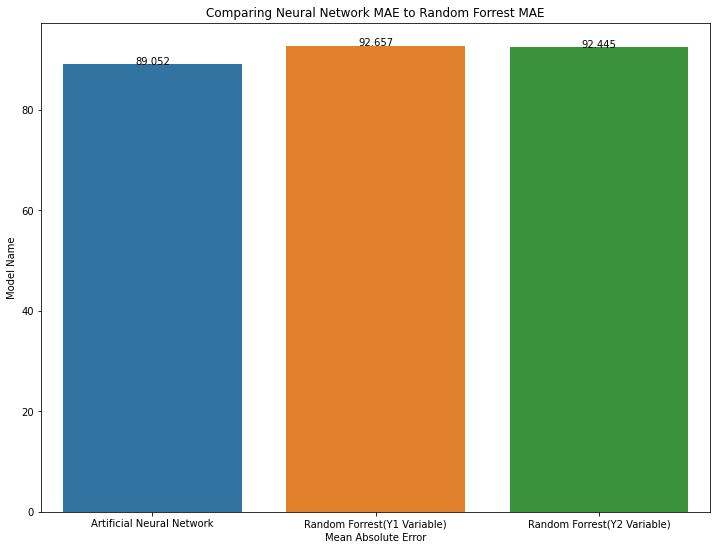

In [457]:
plt.figure(figsize=(12,9))
ax = sns.barplot(y=[ann_r2, rf_r21, rf_r22], x=['Artificial Neural Network', 'Random Forrest(Y1 Variable)', 'Random Forrest(Y2 Variable)'])
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height + 0.01,
          '{:1.3f}'.format(height),
          ha='center')
plt.xlabel('Mean Absolute Error')
plt.ylabel('Model Name')
plt.title('Comparing Neural Network MAE to Random Forrest MAE')